In [258]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as mae

In [261]:
#Loading the features curated previously
df= pd.read_csv('/content/drive/MyDrive/CC5240 ML/ams-2014-solar-energy-prediction-contest/GEFS_Features.csv')
df

,Unnamed: 0,Total_precipitation,Downward_Long_Wave_Rad_Flux,Downward_short_Wave_Rad_Flux,Pressure_mean_sea_level,Precipitable_water,Specific_humidity_height_above_ground,Total_cloud_cover,Total_Column-Integrated_Condensate,Maximum_temperature,Minimum_temperature,Temperature_above_ground,Temperature_surface,Upward_Long-Wave_Rad_Flux_surface,Upward_Long-Wave_Rad_Flux,Upward_Short-Wave_Rad_Flux
0,1994-01-01,0.000000,258.64188,219.09091,102023.780,8.086300,0.003322,0.001273,0.002298,284.39703,280.26060,282.35430,282.54852,364.31976,254.38380,47.745457
1,1994-01-02,0.156364,279.48965,166.90909,101307.500,11.476502,0.003798,0.069091,0.069067,283.79270,279.78730,282.07254,282.33218,358.07530,231.38725,32.618180
2,1994-01-03,0.000000,227.04659,225.32729,101984.930,6.755241,0.002511,0.000909,0.001782,277.42557,273.05588,275.72464,277.42630,335.16843,241.27985,49.072727
3,1994-01-04,0.004545,238.26636,226.21817,102571.125,5.734901,0.002601,0.002727,0.003251,278.94736,275.17150,276.33096,277.47464,342.49518,244.66994,49.527270
4,1994-01-05,0.000000,258.61813,219.45454,100769.320,9.284234,0.003136,0.024364,0.025482,283.42200,278.55490,282.82280,282.66800,353.97708,242.21690,46.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,2007-12-27,0.011818,232.15016,212.72728,101556.650,8.197086,0.003368,0.007091,0.008116,274.60257,271.48923,273.69574,274.65700,320.14722,239.14297,59.636364
5109,2007-12-28,0.046364,226.88014,223.09091,102168.800,6.018736,0.002995,0.017091,0.017351,273.36935,270.51187,271.98865,272.39377,313.22960,235.86493,90.436360
5110,2007-12-29,0.001818,232.12694,209.81818,102100.625,8.348250,0.002958,0.048727,0.049416,274.08610,269.55620,272.73972,272.60520,309.80417,223.78389,82.581820
5111,2007-12-30,0.000000,224.02965,228.36363,101760.260,4.311398,0.003054,0.000000,0.000593,276.13943,271.73752,274.70680,273.83890,316.94860,242.54750,85.890910


In [262]:
#Setting the index to the dates
idx= pd.date_range(start='1994-01-01',end='2007-12-31', freq= 'd')
df.set_index(idx, inplace= True)
df.drop('Unnamed: 0',axis=1,inplace= True)

In [263]:
df

,Total_precipitation,Downward_Long_Wave_Rad_Flux,Downward_short_Wave_Rad_Flux,Pressure_mean_sea_level,Precipitable_water,Specific_humidity_height_above_ground,Total_cloud_cover,Total_Column-Integrated_Condensate,Maximum_temperature,Minimum_temperature,Temperature_above_ground,Temperature_surface,Upward_Long-Wave_Rad_Flux_surface,Upward_Long-Wave_Rad_Flux,Upward_Short-Wave_Rad_Flux
1994-01-01,0.000000,258.64188,219.09091,102023.780,8.086300,0.003322,0.001273,0.002298,284.39703,280.26060,282.35430,282.54852,364.31976,254.38380,47.745457
1994-01-02,0.156364,279.48965,166.90909,101307.500,11.476502,0.003798,0.069091,0.069067,283.79270,279.78730,282.07254,282.33218,358.07530,231.38725,32.618180
1994-01-03,0.000000,227.04659,225.32729,101984.930,6.755241,0.002511,0.000909,0.001782,277.42557,273.05588,275.72464,277.42630,335.16843,241.27985,49.072727
1994-01-04,0.004545,238.26636,226.21817,102571.125,5.734901,0.002601,0.002727,0.003251,278.94736,275.17150,276.33096,277.47464,342.49518,244.66994,49.527270
1994-01-05,0.000000,258.61813,219.45454,100769.320,9.284234,0.003136,0.024364,0.025482,283.42200,278.55490,282.82280,282.66800,353.97708,242.21690,46.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-27,0.011818,232.15016,212.72728,101556.650,8.197086,0.003368,0.007091,0.008116,274.60257,271.48923,273.69574,274.65700,320.14722,239.14297,59.636364
2007-12-28,0.046364,226.88014,223.09091,102168.800,6.018736,0.002995,0.017091,0.017351,273.36935,270.51187,271.98865,272.39377,313.22960,235.86493,90.436360
2007-12-29,0.001818,232.12694,209.81818,102100.625,8.348250,0.002958,0.048727,0.049416,274.08610,269.55620,272.73972,272.60520,309.80417,223.78389,82.581820
2007-12-30,0.000000,224.02965,228.36363,101760.260,4.311398,0.003054,0.000000,0.000593,276.13943,271.73752,274.70680,273.83890,316.94860,242.54750,85.890910


In [264]:
df.groupby(df.index.month).mean()

,Total_precipitation,Downward_Long_Wave_Rad_Flux,Downward_short_Wave_Rad_Flux,Pressure_mean_sea_level,Precipitable_water,Specific_humidity_height_above_ground,Total_cloud_cover,Total_Column-Integrated_Condensate,Maximum_temperature,Minimum_temperature,Temperature_above_ground,Temperature_surface,Upward_Long-Wave_Rad_Flux_surface,Upward_Long-Wave_Rad_Flux,Upward_Short-Wave_Rad_Flux
1,1.216424,263.762742,211.170423,102088.354942,10.359110,0.003633,0.066968,0.067259,279.752681,276.282758,278.453191,279.255491,344.839752,233.080210,50.602681
2,1.392152,274.634909,267.584903,101955.885304,11.206959,0.004153,0.076787,0.077018,282.236639,278.565699,281.097684,282.528875,359.662591,231.639398,56.956824
3,2.297981,296.067446,330.530038,101659.521820,14.003548,0.005663,0.096191,0.096463,286.420599,282.440067,285.397673,286.979077,381.014341,240.741127,63.976917
4,2.066978,317.323591,414.196666,101354.510250,17.166017,0.007979,0.071964,0.072253,291.229496,286.832137,290.175746,291.169594,402.870618,251.246410,76.680606
5,2.858226,356.159134,452.365439,101245.948629,25.675736,0.011599,0.072174,0.072487,296.494209,292.292318,295.540338,296.457755,433.093274,257.004629,82.574151
6,2.898225,381.794298,491.593940,101257.256845,32.667683,0.013795,0.050481,0.050832,300.888042,296.740132,299.984142,301.026011,460.099667,271.596949,90.979048
7,1.740536,396.973355,487.615667,101400.221106,35.712700,0.013880,0.032963,0.033368,303.796815,299.484520,302.808676,303.987243,478.350363,278.653771,91.835986
8,2.017099,395.721629,449.219271,101438.194297,35.687304,0.013510,0.033209,0.033573,303.562777,299.185398,302.488043,303.639527,476.642974,278.054265,84.545245
9,1.960593,362.234535,385.648918,101501.621583,28.164761,0.010986,0.038962,0.039316,298.671852,294.240853,297.376741,298.321449,445.770408,274.464609,74.503809
10,2.773228,326.057220,294.651612,101660.819643,20.423324,0.008105,0.062929,0.063227,292.472329,288.186130,290.976002,291.687930,409.099085,261.869122,59.711018


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5113 entries, 1994-01-01 to 2007-12-31
Freq: D
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Total_precipitation                    5113 non-null   float64
 1   Downward_Long_Wave_Rad_Flux            5113 non-null   float64
 2   Downward_short_Wave_Rad_Flux           5113 non-null   float64
 3   Pressure_mean_sea_level                5113 non-null   float64
 4   Precipitable_water                     5113 non-null   float64
 5   Specific_humidity_height_above_ground  5113 non-null   float64
 6   Total_cloud_cover                      5113 non-null   float64
 7   Total_Column-Integrated_Condensate     5113 non-null   float64
 8   Maximum_temperature                    5113 non-null   float64
 9   Minimum_temperature                    5113 non-null   float64
 10  Temperature_above_ground               5113 no

In [266]:
df.describe()

,Total_precipitation,Downward_Long_Wave_Rad_Flux,Downward_short_Wave_Rad_Flux,Pressure_mean_sea_level,Precipitable_water,Specific_humidity_height_above_ground,Total_cloud_cover,Total_Column-Integrated_Condensate,Maximum_temperature,Minimum_temperature,Temperature_above_ground,Temperature_surface,Upward_Long-Wave_Rad_Flux_surface,Upward_Long-Wave_Rad_Flux,Upward_Short-Wave_Rad_Flux
count,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000
mean,2.038440,327.666015,349.792003,101629.749028,21.361173,0.008590,0.061626,0.061940,291.834824,287.782534,290.666602,291.642275,409.297481,255.045237,68.884953
std,6.239318,57.886925,131.698654,720.117845,11.897345,0.004595,0.130643,0.130524,9.703908,9.407525,9.768205,9.758674,52.749812,34.328205,24.255929
min,0.000000,176.778500,16.545454,98999.090000,1.350021,0.000504,0.000000,0.000053,258.950070,254.032410,257.689970,259.605600,252.668150,126.062740,2.309091
25%,0.000000,279.232540,238.472720,101167.555000,11.002326,0.004402,0.000545,0.001185,284.334440,280.491520,283.026030,284.019800,366.657800,236.964660,51.309093
50%,0.001818,329.166230,357.745450,101561.160000,18.866564,0.008123,0.008545,0.008882,292.413360,288.195600,291.300080,292.234530,408.725400,259.734220,71.527275
75%,0.752727,381.395020,472.054570,102037.830000,31.066687,0.012755,0.058909,0.059076,300.328500,296.117400,299.281740,300.271670,456.202330,280.818940,89.309090
max,110.043630,434.876740,560.581800,104464.770000,56.478554,0.020461,1.487636,1.487377,309.482150,304.483520,308.115260,309.122280,511.686000,322.745640,195.618180


In [267]:
#Feature wise correlation
df.corr()

,Total_precipitation,Downward_Long_Wave_Rad_Flux,Downward_short_Wave_Rad_Flux,Pressure_mean_sea_level,Precipitable_water,Specific_humidity_height_above_ground,Total_cloud_cover,Total_Column-Integrated_Condensate,Maximum_temperature,Minimum_temperature,Temperature_above_ground,Temperature_surface,Upward_Long-Wave_Rad_Flux_surface,Upward_Long-Wave_Rad_Flux,Upward_Short-Wave_Rad_Flux
Total_precipitation,1.000000,0.231584,-0.285706,-0.119557,0.307825,0.191357,0.747929,0.748076,0.000824,0.048082,0.007330,-0.007101,0.000612,-0.417127,-0.336912
Downward_Long_Wave_Rad_Flux,0.231584,1.000000,0.444123,-0.548758,0.932493,0.946379,0.155117,0.155090,0.886944,0.921072,0.896216,0.890255,0.898775,0.282496,0.262848
Downward_short_Wave_Rad_Flux,-0.285706,0.444123,1.000000,-0.281799,0.371781,0.535522,-0.508056,-0.507714,0.700249,0.655730,0.700460,0.725369,0.714687,0.657840,0.920798
Pressure_mean_sea_level,-0.119557,-0.548758,-0.281799,1.000000,-0.408959,-0.529257,-0.042112,-0.042214,-0.578187,-0.588212,-0.579063,-0.559468,-0.548808,-0.231170,-0.137673
Precipitable_water,0.307825,0.932493,0.371781,-0.408959,1.000000,0.917863,0.201280,0.201267,0.775463,0.814613,0.787018,0.785283,0.797110,0.156615,0.215956
Specific_humidity_height_above_ground,0.191357,0.946379,0.535522,-0.529257,0.917863,1.000000,0.036892,0.036932,0.877424,0.902713,0.887558,0.883819,0.888530,0.352069,0.377827
Total_cloud_cover,0.747929,0.155117,-0.508056,-0.042112,0.201280,0.036892,1.000000,0.999993,-0.157618,-0.097362,-0.146291,-0.163703,-0.156994,-0.684183,-0.568372
Total_Column-Integrated_Condensate,0.748076,0.155090,-0.507714,-0.042214,0.201267,0.036932,0.999993,1.000000,-0.157429,-0.097204,-0.146109,-0.163522,-0.156814,-0.683777,-0.568004
Maximum_temperature,0.000824,0.886944,0.700249,-0.578187,0.775463,0.877424,-0.157618,-0.157429,1.000000,0.993569,0.998683,0.995965,0.994640,0.558800,0.523542
Minimum_temperature,0.048082,0.921072,0.655730,-0.588212,0.814613,0.902713,-0.097362,-0.097204,0.993569,1.000000,0.994992,0.990628,0.991863,0.512228,0.473256


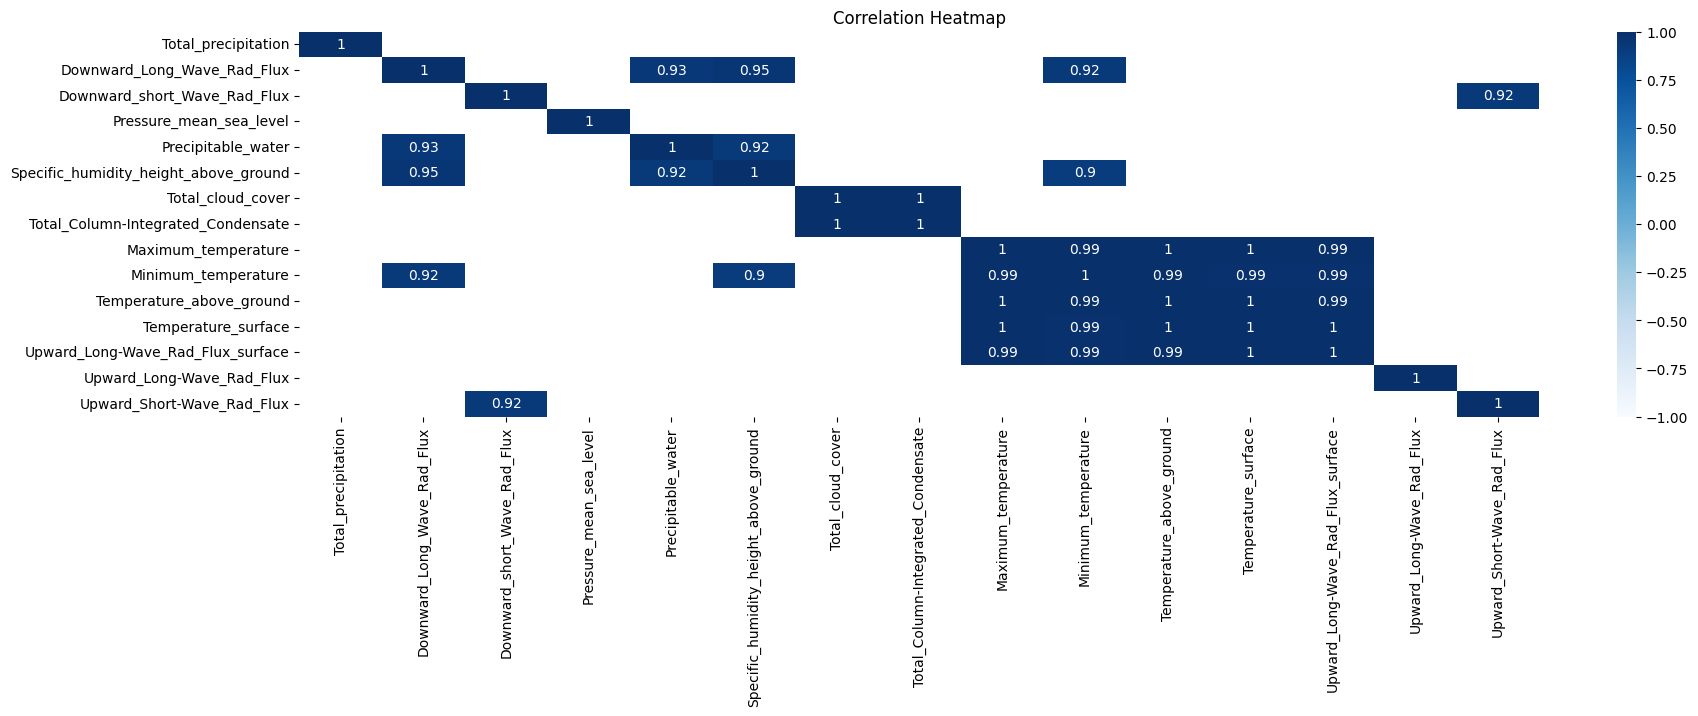

In [268]:
#drawing correlation heat map
fig,ax= plt.subplots(figsize= (20,5))
corr=df.corr()
high_corr= corr[(corr>0.9) | (corr<-0.9)]
sns.heatmap(high_corr,cmap='Blues',annot=True, vmin= -1)
plt.title('Correlation Heatmap');


In [269]:
#MESONET data for 98 Oklahoma Sites
solar_df= pd.read_csv('/content/drive/MyDrive/CC5240 ML/ams-2014-solar-energy-prediction-contest/solar_training_199401_200712.csv')
solar_df

,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,VINI,WASH,WATO,WAUR,WEAT,WEST,WILB,WIST,WOOD,WYNO
0,19940101,12384900.0,11930700.0,12116700.0,12301200.0,10706100.0,10116900.0,11487900.0,11182800.0,10848300.0,...,10771800.0,12116400.0,11308800.0,12361800.0,11331600.0,10644300.0,11715600.0,11241000.0,10490100.0,10545300.0
1,19940102,11908500.0,9778500.0,10862700.0,11666400.0,8062500.0,9262800.0,9235200.0,3963300.0,3318300.0,...,4314300.0,10733400.0,9154800.0,12041400.0,9168300.0,4082700.0,9228000.0,5829900.0,7412100.0,3345300.0
2,19940103,12470700.0,9771900.0,12627300.0,12782700.0,11618400.0,10789800.0,11895900.0,4512600.0,5266500.0,...,2976900.0,11775000.0,10700400.0,12687300.0,11324400.0,2746500.0,3686700.0,4488900.0,9712200.0,4442100.0
3,19940104,12725400.0,6466800.0,13065300.0,12817500.0,12134400.0,11816700.0,12186600.0,3212700.0,8270100.0,...,3476400.0,12159600.0,11907000.0,12953100.0,11903700.0,2741400.0,4905000.0,4089300.0,11401500.0,4365000.0
4,19940105,10894800.0,11545200.0,8060400.0,10379400.0,6918600.0,9936300.0,6411300.0,9566100.0,8009400.0,...,6393300.0,11419500.0,7334400.0,10178700.0,7471500.0,8235300.0,11159100.0,10651500.0,10006200.0,8568300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,20071227,1408500.0,1371000.0,1742400.0,1389300.0,1349400.0,1466400.0,1245900.0,1674000.0,922500.0,...,1511100.0,1220700.0,1083300.0,1887900.0,1467900.0,1404000.0,1510500.0,1747500.0,1079100.0,1100400.0
5109,20071228,10060800.0,6581700.0,12027300.0,11312100.0,9665100.0,7993800.0,11962200.0,9010500.0,5747700.0,...,3735600.0,7612500.0,6875700.0,12105300.0,11741700.0,3844800.0,7136100.0,5670000.0,7592400.0,6705900.0
5110,20071229,11388000.0,11353800.0,11946900.0,9662400.0,10938300.0,11315100.0,11402400.0,10683300.0,8954400.0,...,10457700.0,10316700.0,10559700.0,11873100.0,11369400.0,10711500.0,11822100.0,11594100.0,9687900.0,10586400.0
5111,20071230,12441000.0,11883300.0,12409200.0,12155400.0,11937600.0,12314100.0,12006000.0,11695800.0,10249500.0,...,11152800.0,12258900.0,12251100.0,12754200.0,12230100.0,11771100.0,12162900.0,11933400.0,10940700.0,11281800.0


In [270]:
#Setting aside the train and test data
train_df=df.iloc[:-365].copy()
test_df=df.iloc[-365:].copy()

In [271]:
train_df.columns[:]

Index(['Total_precipitation', 'Downward_Long_Wave_Rad_Flux',
       'Downward_short_Wave_Rad_Flux', 'Pressure_mean_sea_level',
       'Precipitable_water', 'Specific_humidity_height_above_ground',
       'Total_cloud_cover', 'Total_Column-Integrated_Condensate',
       'Maximum_temperature', 'Minimum_temperature',
       'Temperature_above_ground', 'Temperature_surface',
       'Upward_Long-Wave_Rad_Flux_surface', 'Upward_Long-Wave_Rad_Flux',
       'Upward_Short-Wave_Rad_Flux'],
      dtype='object')

In [272]:
#Storing name of the features and label
features= train_df.columns[:]
label= 'radiation'

In [273]:
#Putting the label column in train and test datasets
train_df[label]= solar_df['WEAT'][:-365].values
test_df[label]=solar_df['WEAT'][-365:].values

In [274]:
train_df[label]

1994-01-01    11331600.0
1994-01-02     9168300.0
1994-01-03    11324400.0
1994-01-04    11903700.0
1994-01-05     7471500.0
                 ...    
2006-12-27    11163600.0
2006-12-28     3122700.0
2006-12-29     1216800.0
2006-12-30     5183700.0
2006-12-31     9177300.0
Freq: D, Name: radiation, Length: 4748, dtype: float64

In [275]:
#Dividing the data into features and labels for training
x_train = train_df[features]
y_train = train_df[label]

In [276]:
#Dividing the data into features and labels for testing
x_test= test_df[features]
y_test= test_df[label]

In [277]:
print(x_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4748 entries, 1994-01-01 to 2006-12-31
Freq: D
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Total_precipitation                    4748 non-null   float64
 1   Downward_Long_Wave_Rad_Flux            4748 non-null   float64
 2   Downward_short_Wave_Rad_Flux           4748 non-null   float64
 3   Pressure_mean_sea_level                4748 non-null   float64
 4   Precipitable_water                     4748 non-null   float64
 5   Specific_humidity_height_above_ground  4748 non-null   float64
 6   Total_cloud_cover                      4748 non-null   float64
 7   Total_Column-Integrated_Condensate     4748 non-null   float64
 8   Maximum_temperature                    4748 non-null   float64
 9   Minimum_temperature                    4748 non-null   float64
 10  Temperature_above_ground               4748 no

## Priliminary Model

In [278]:
tss = TimeSeriesSplit( test_size=365)  #Creating Timeseries splitting object.
scores=[]
preds=[]
for train_index, val_index in tss.split(train_df):
  traindf= train_df.copy()
  train = traindf.iloc[train_index]
  val = traindf.iloc[val_index]

  #Putting all the FEATURES in the x_train and the TARGET in y_train for training the model.
  x_train = train[features]
  y_train = train[label]

  #Putting all the FEATURES in the x_val and the TARGET in y_val for validating the model.
  x_val = val[features]
  y_val = val[label]

  #creating the regressor model named reg
  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          max_depth=5,
                          learning_rate=0.01, )
  #fitting the training data and simultaneously evaluting RMS Error in both train and test data
  reg.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_val, y_val)],
          verbose=200)
  #predicted value
  y_pred = reg.predict(x_val)
  #putting the predicted values in the list
  preds.append(y_pred)

  #Keeping score of the error
  score = np.sqrt(mean_squared_error(y_val, y_pred))
  scores.append(score)

[0]	validation_0-rmse:18776086.31915	validation_1-rmse:17695755.17663
[200]	validation_0-rmse:3861306.35656	validation_1-rmse:3585153.70683
[385]	validation_0-rmse:2606555.48713	validation_1-rmse:3101146.96532
[0]	validation_0-rmse:18660228.39530	validation_1-rmse:18051830.82168
[200]	validation_0-rmse:3864378.86502	validation_1-rmse:4045775.07709
[400]	validation_0-rmse:2607367.13447	validation_1-rmse:3614116.53190
[600]	validation_0-rmse:2383077.81017	validation_1-rmse:3585146.27777
[800]	validation_0-rmse:2235696.13461	validation_1-rmse:3564317.80268
[940]	validation_0-rmse:2144719.92681	validation_1-rmse:3562464.50564
[0]	validation_0-rmse:18600981.17141	validation_1-rmse:18060358.69924
[200]	validation_0-rmse:3904442.68373	validation_1-rmse:4175820.70098
[400]	validation_0-rmse:2663041.78342	validation_1-rmse:3351229.32064
[600]	validation_0-rmse:2448342.02986	validation_1-rmse:3330672.80511
[636]	validation_0-rmse:2416909.79248	validation_1-rmse:3338035.51548
[0]	validation_0-rms

In [279]:
#RMSE for each validation
print('RMSE scores are: ')
scores

RMSE scores are: 


[3099903.562291726,
 3561758.404693611,
 3330138.6255489113,
 3375024.8377854764,
 2797839.3000227613]

In [280]:
# Retrain on all data
x_all = train_df[features]
y_all = train_df[label]

reg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:18619121.60863
[100]	validation_0-rmse:7476727.93653
[200]	validation_0-rmse:3929596.95771
[300]	validation_0-rmse:3008243.33272
[400]	validation_0-rmse:2755662.06719
[500]	validation_0-rmse:2642194.21761
[600]	validation_0-rmse:2568531.35602
[700]	validation_0-rmse:2509219.58855
[800]	validation_0-rmse:2454884.62773
[900]	validation_0-rmse:2397479.67987
[999]	validation_0-rmse:2337627.39427


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

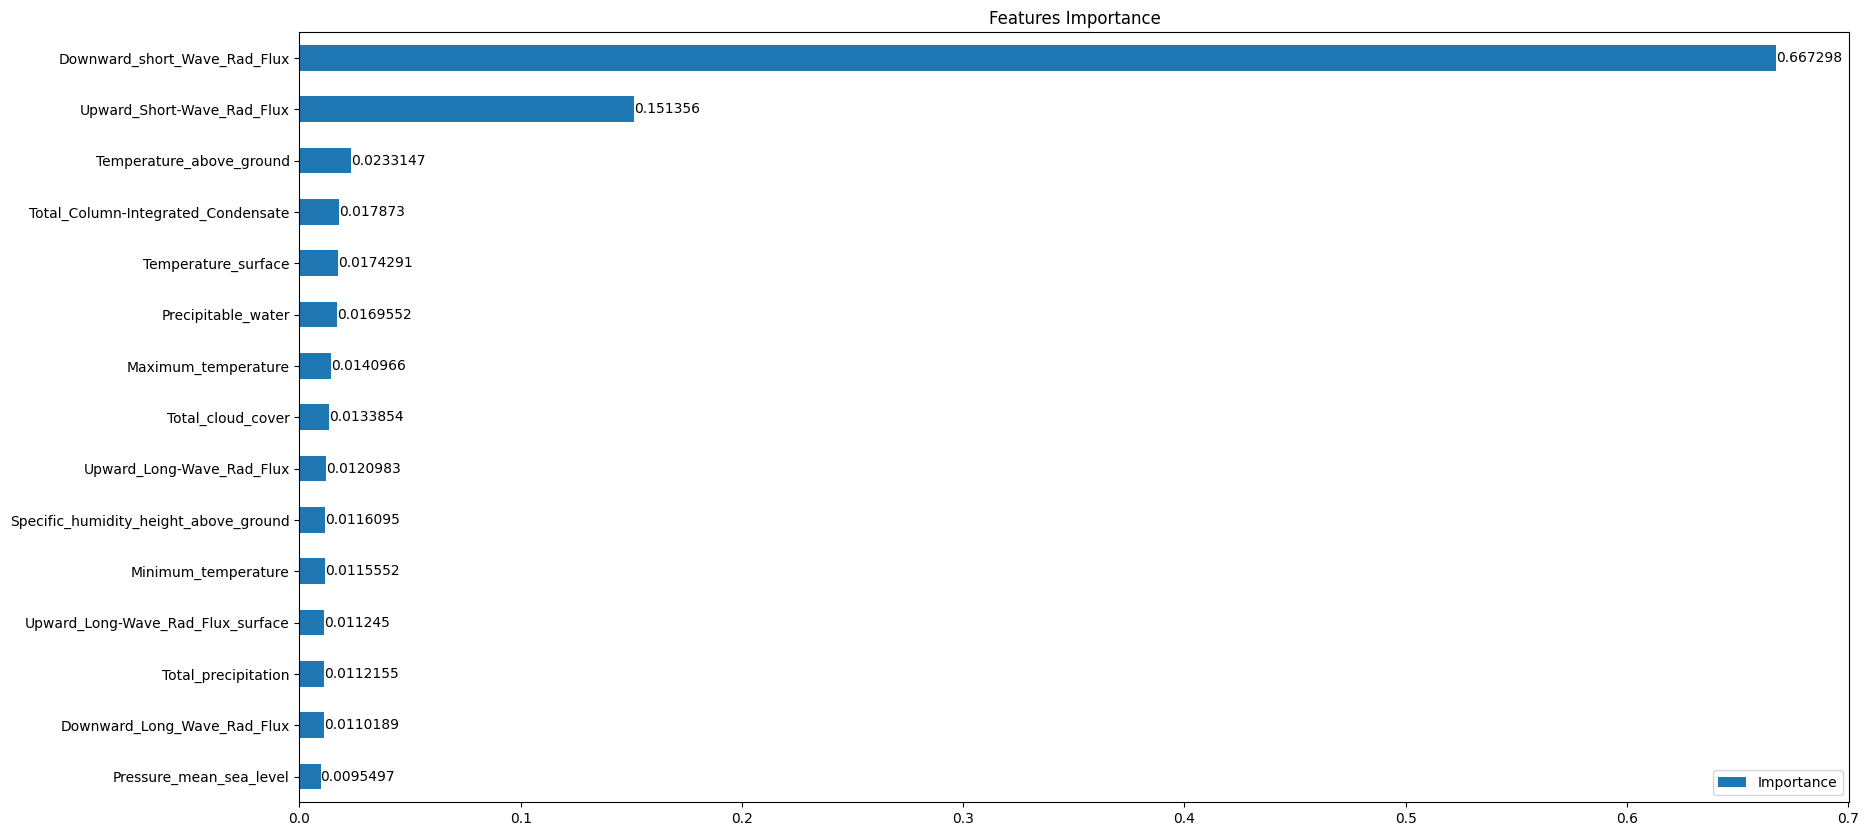

In [281]:
#Feature importance for the Random Forest Creation
feat_imp= pd.DataFrame(data= reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['Importance'])
ax=feat_imp.sort_values('Importance').plot(kind='barh',title= 'Features Importance')
ax.bar_label(ax.containers[0]);

In [282]:
#predicting the solar radiation for the test data
prediction= reg.predict(x_test)

In [283]:
plt.rcParams['figure.figsize']=[20,10]

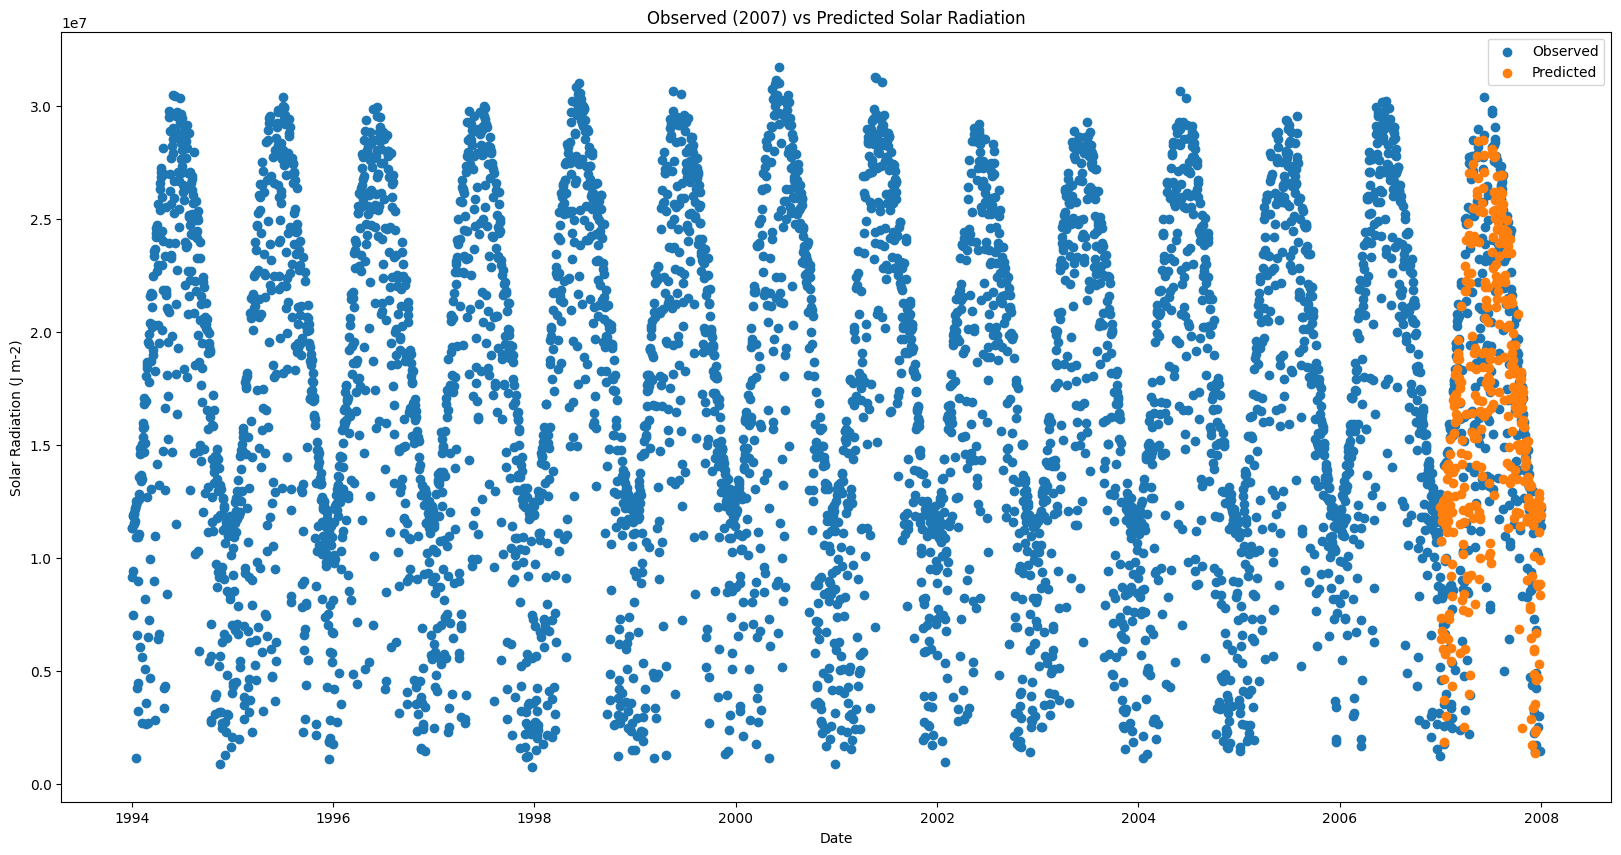

In [284]:
plt.scatter(df.index,solar_df['WEAT'], label='Observed' )
plt.scatter(test_df.index,prediction, label= 'Predicted')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (J m-2)')
plt.title('Observed (2007) vs Predicted Solar Radiation')
plt.legend();

In [285]:
"""plt.scatter(train_df.index,train_df['radiation'], label='Observed' )
plt.scatter(test_df.index,prediction, label= 'Predicted')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (J m-2)')
plt.legend();"""

"plt.scatter(train_df.index,train_df['radiation'], label='Observed' )\nplt.scatter(test_df.index,prediction, label= 'Predicted')\nplt.xlabel('Date')\nplt.ylabel('Solar Radiation (J m-2)')\nplt.legend();"

In [286]:
#Test Scores

In [287]:
#R2 Score for the Primary Model
pri_r2= reg.score(x_test, y_test)
pri_r2

0.7829287471590258

In [288]:
#Mean Absolute Erron
pri_mae= mae(prediction,y_test)
pri_mae


2390521.4407534245

In [289]:
#RMSE
pri_rmse= np.sqrt(mean_squared_error(prediction,y_test))
pri_rmse

3313316.317777842

In [290]:
test_df['Primary Prediction']= prediction
test_df['error']= test_df['Primary Prediction']- test_df['radiation']

In [291]:
mean_monthly_error= test_df['error'].groupby(test_df.index.month).mean()

In [292]:
abs_mean_monthly_error= abs(test_df['error']).groupby(test_df.index.month).mean()

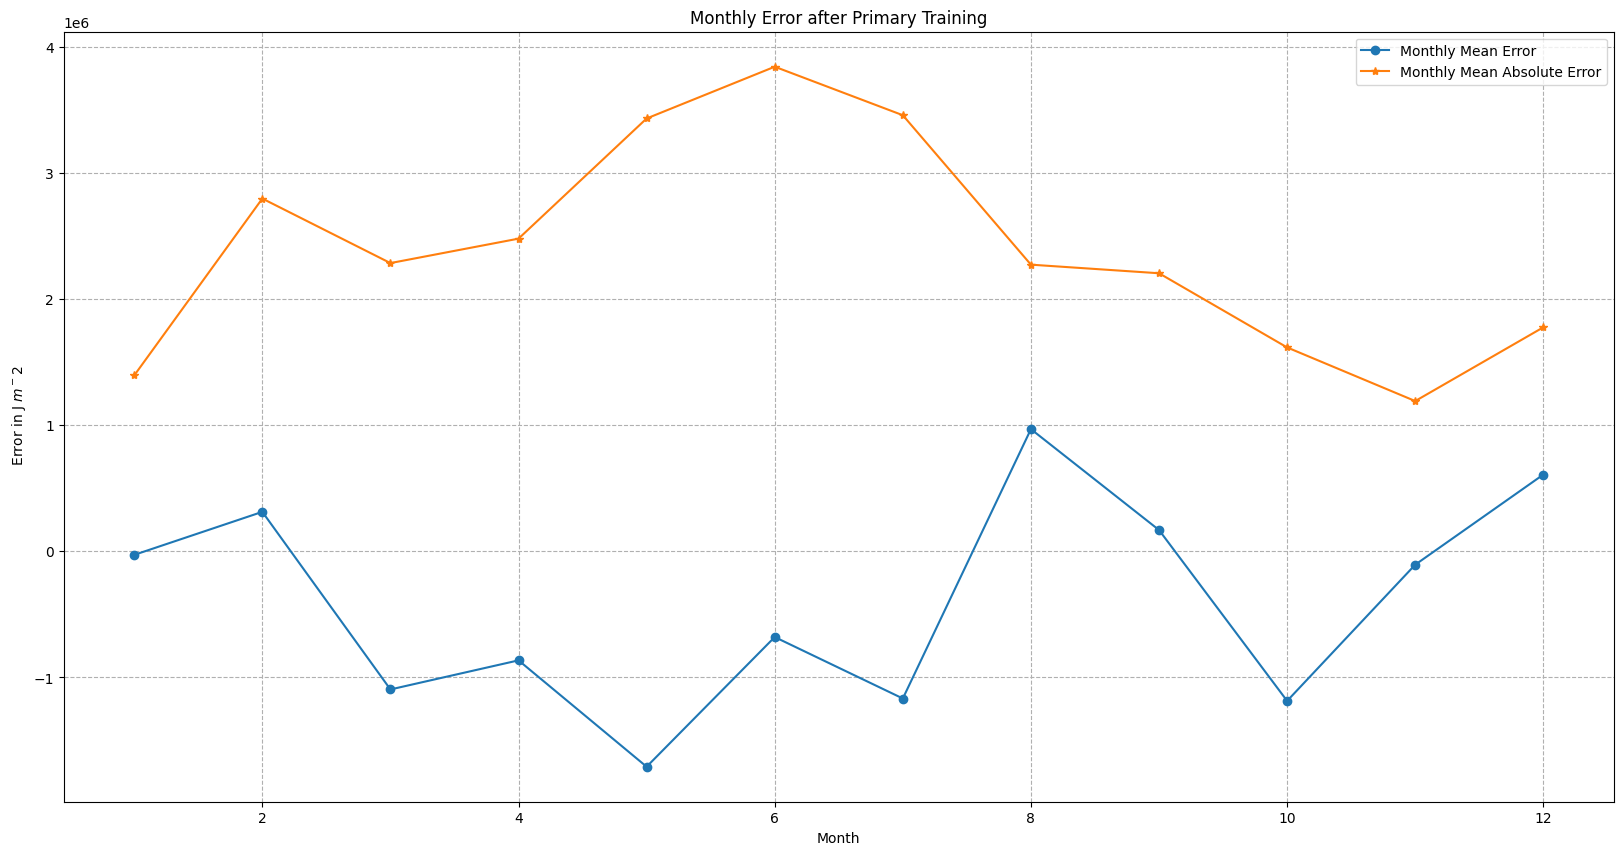

In [293]:
plt.plot(test_df.index.month.unique(), mean_monthly_error, '-o', label= 'Monthly Mean Error')
plt.plot(test_df.index.month.unique(), abs_mean_monthly_error,'-*', label='Monthly Mean Absolute Error')

plt.xlabel('Month')
plt.ylabel(' Error in J $m^-2$')
plt.title('Monthly Error after Primary Training')
plt.grid(linestyle='--')
plt.legend();

##xAI

####Permutation

In [294]:
from sklearn.inspection import permutation_importance

Baseline RMSE value from Testing: 3313316.317777842

In [295]:
base_rmse= 3313316.317777842

In [296]:
# Compute permutation importance
result = permutation_importance(reg, x_test, y_test, scoring='neg_root_mean_squared_error', random_state=40)
result.importances

array([[ 1.42136741e+05,  9.37799448e+04,  7.04698645e+04,
         7.78310837e+04,  1.17401212e+05],
       [ 4.11073261e+05,  4.20708347e+05,  3.63414332e+05,
         5.28944023e+05,  4.36212733e+05],
       [ 3.71701578e+06,  3.96904180e+06,  3.88768813e+06,
         3.58821339e+06,  3.43300274e+06],
       [ 1.16802744e+04,  4.97100582e+04,  3.08296124e+04,
         7.14626176e+04,  9.79721471e+03],
       [ 1.73936163e+06,  1.80769949e+06,  1.66364593e+06,
         1.41145177e+06,  1.82158571e+06],
       [ 1.61727295e+05,  1.43436676e+05,  1.20701931e+05,
         1.50258594e+05,  9.20111866e+04],
       [ 4.29965318e+05,  6.76784642e+05,  5.44939277e+05,
         5.14656467e+05,  2.93128442e+05],
       [ 4.30049667e+04,  7.54462851e+04,  3.76120509e+04,
         7.13987282e+04,  6.89952181e+04],
       [ 1.15714206e+05,  1.12103260e+05,  1.22359892e+05,
         1.63282113e+05,  9.62923606e+04],
       [ 1.22282251e+05,  1.32437359e+05,  8.48090361e+04,
         1.30840833e+05

In [297]:
# Compute scores after permutation
perm_scores = result.importances_mean

In [298]:
result.importances_mean

array([ 100323.76909845,  432070.53902279, 3718992.36670403,
         34695.95545516, 1688748.90584257,  133627.13637078,
        491894.829382  ,   59291.4497936 ,  121950.36639906,
        113468.62662164, 1055284.47587976,   90447.89531584,
          7306.64437167,   47114.88839945,  543295.11783059])

In [299]:
result.importances_std

array([ 26381.66715313,  54194.63000077, 194874.36860321,  23417.20820216,
       149586.34165347,  24744.29054745, 127168.69839591,  15728.78812022,
        22372.61484422,  19145.45696891,  48316.27842061,   8034.62823815,
        14480.46050731,  23549.63110339,  20674.90676464])

In [300]:
x_train.columns

Index(['Total_precipitation', 'Downward_Long_Wave_Rad_Flux',
       'Downward_short_Wave_Rad_Flux', 'Pressure_mean_sea_level',
       'Precipitable_water', 'Specific_humidity_height_above_ground',
       'Total_cloud_cover', 'Total_Column-Integrated_Condensate',
       'Maximum_temperature', 'Minimum_temperature',
       'Temperature_above_ground', 'Temperature_surface',
       'Upward_Long-Wave_Rad_Flux_surface', 'Upward_Long-Wave_Rad_Flux',
       'Upward_Short-Wave_Rad_Flux'],
      dtype='object')

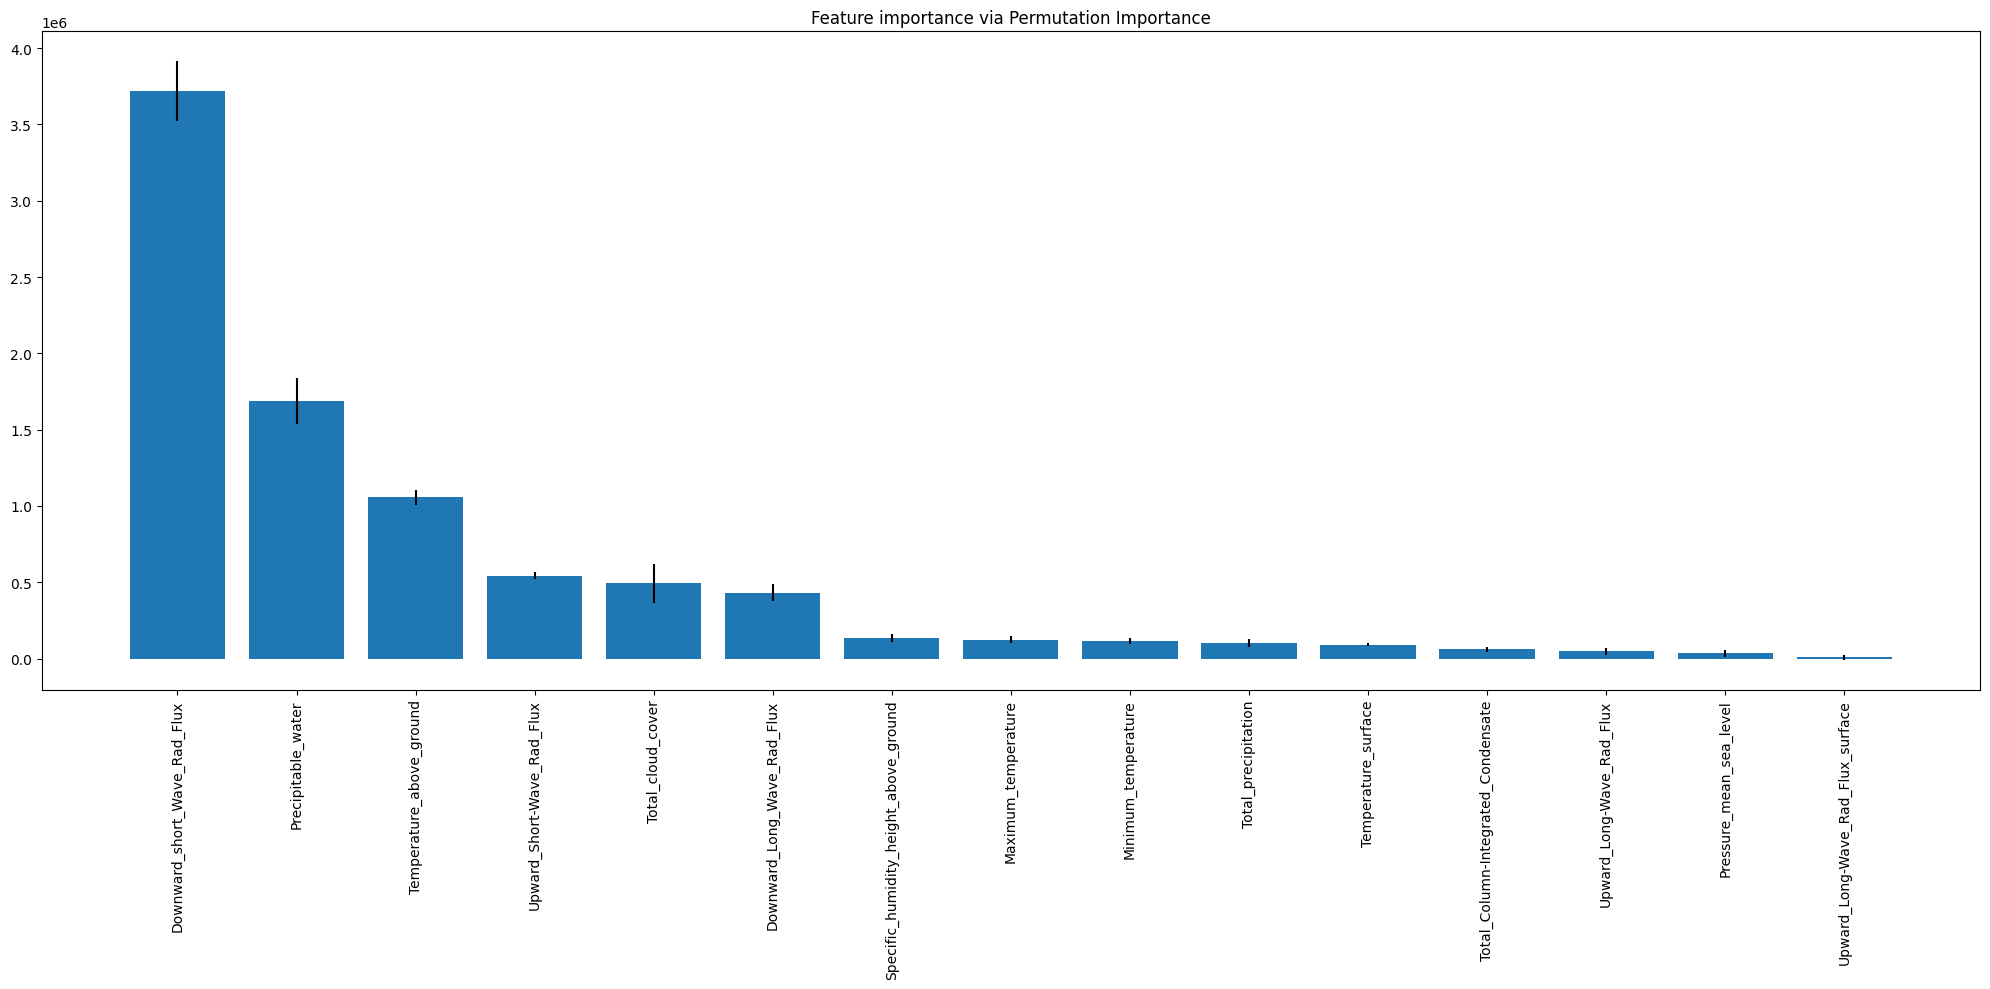

In [301]:
#Visualise
indices = np.argsort(result['importances_mean'])[::-1]

plt.figure()
plt.title("Feature importance via Permutation Importance")
plt.bar(
    range(x_test.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

feature_names = x_train.columns.values
plt.xticks(range(x_train.shape[1]), feature_names[indices], rotation=90)


plt.tight_layout()

From the Correlation Heatmap we already knew that a few features had high correlation. Now we can see for the Permutaion Importance about the important features. So using both we are removing the features which are highly correlated with a more important feature.

##Retraining with Reduced Features

In [302]:
features

Index(['Total_precipitation', 'Downward_Long_Wave_Rad_Flux',
       'Downward_short_Wave_Rad_Flux', 'Pressure_mean_sea_level',
       'Precipitable_water', 'Specific_humidity_height_above_ground',
       'Total_cloud_cover', 'Total_Column-Integrated_Condensate',
       'Maximum_temperature', 'Minimum_temperature',
       'Temperature_above_ground', 'Temperature_surface',
       'Upward_Long-Wave_Rad_Flux_surface', 'Upward_Long-Wave_Rad_Flux',
       'Upward_Short-Wave_Rad_Flux'],
      dtype='object')

In [303]:
new_features= ['Total_precipitation', 'Downward_Long_Wave_Rad_Flux',
               'Downward_short_Wave_Rad_Flux', 'Pressure_mean_sea_level',
               'Precipitable_water','Specific_humidity_height_above_ground',
               'Total_cloud_cover','Temperature_above_ground',
               'Upward_Long-Wave_Rad_Flux','Upward_Short-Wave_Rad_Flux']

In [304]:
#training similarly like the previous case
tss = TimeSeriesSplit( test_size=365)
new_scores=[]
new_preds=[]
for train_index, val_index in tss.split(train_df):
  traindf= train_df.copy()
  train = traindf.iloc[train_index]
  val = traindf.iloc[val_index]

  #Putting all the FEATURES in the new_x_train and the TARGET in new_y_train for training the model.
  new_x_train = train[new_features]
  new_y_train = train[label]

  #Putting all the FEATURES in the new_x_val and the TARGET in new_y_val for validating the model.
  new_x_val = val[new_features]
  new_y_val = val[label]

  #creating the regressor model named new_reg
  new_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          #early_stopping_rounds=50,
                          max_depth=5,
                          learning_rate=0.01)

  #fitting the training data and simultaneously evaluting RMS Error in both train and test data
  new_reg.fit(new_x_train, new_y_train,
          eval_set=[(new_x_train, new_y_train), (new_x_val, new_y_val)],
          verbose=200)
  #predicted value
  new_y_pred = new_reg.predict(new_x_val)
  #putting the predicted values in the list
  new_preds.append(new_y_pred)

  #Keeping new_score of the error
  new_score = np.sqrt(mean_squared_error(new_y_val, new_y_pred))
  new_scores.append(new_score)

[0]	validation_0-rmse:18776100.43129	validation_1-rmse:17695815.17324
[200]	validation_0-rmse:3868374.63021	validation_1-rmse:3610208.72659
[400]	validation_0-rmse:2594990.64253	validation_1-rmse:3118432.28520
[600]	validation_0-rmse:2372891.08681	validation_1-rmse:3188328.37757
[800]	validation_0-rmse:2197912.10078	validation_1-rmse:3239143.10726
[999]	validation_0-rmse:2047377.62251	validation_1-rmse:3252726.22221
[0]	validation_0-rmse:18660228.83599	validation_1-rmse:18051828.46196
[200]	validation_0-rmse:3876619.19320	validation_1-rmse:4049439.95587
[400]	validation_0-rmse:2617565.99942	validation_1-rmse:3607802.99667
[600]	validation_0-rmse:2412738.16704	validation_1-rmse:3569498.69681
[800]	validation_0-rmse:2253328.45983	validation_1-rmse:3546379.65122
[999]	validation_0-rmse:2107280.42564	validation_1-rmse:3526870.68920
[0]	validation_0-rmse:18600995.37691	validation_1-rmse:18060356.56379
[200]	validation_0-rmse:3910782.64740	validation_1-rmse:4171564.12731
[400]	validation_0-r

In [305]:
new_scores

[3252726.2246339633,
 3526870.689280325,
 3366478.832536072,
 3398049.7914038342,
 2804689.968620502]

In [306]:
# Retrain on all data with new_features

new_x_all = train_df[new_features]
new_y_all = train_df[label]

new_reg.fit(new_x_all, new_y_all,
        eval_set=[(new_x_all, new_y_all)],
        verbose=100)

[0]	validation_0-rmse:18619126.78421
[100]	validation_0-rmse:7479350.52837
[200]	validation_0-rmse:3937097.67249
[300]	validation_0-rmse:3022091.63907
[400]	validation_0-rmse:2765492.19476
[500]	validation_0-rmse:2650265.97146
[600]	validation_0-rmse:2580556.87993
[700]	validation_0-rmse:2514221.44785
[800]	validation_0-rmse:2456500.79947
[900]	validation_0-rmse:2401075.71852
[999]	validation_0-rmse:2350612.54006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [307]:
new_prediction= new_reg.predict(test_df[new_features])

In [308]:
#Test Scores

In [309]:
#R2 Score
new_r2 = new_reg.score(test_df[new_features], y_test)
new_r2

0.7846826558844314

In [310]:
#Change in R2 Score
new_r2 - pri_r2

0.0017539087254055952

R2 score has increased by 0.001

In [311]:

#Mean Absolute Error
new_mae= mae(new_prediction, y_test)
new_mae

2392578.7051369864

Previous MEA: 2390521.4407534245


In [312]:
#(previous-new) mae
new_mae-pri_mae

2057.264383561909

MAE has increased by 2057.264

In [313]:
#RMSE
new_rmse= np.sqrt(mean_squared_error(new_prediction,y_test))
new_rmse

3299903.57762769

Previous RMSE: 3313316.317777842

In [314]:
#Change in RMSE
new_rmse- pri_rmse

-13412.740150151774

RMSE value has decreased by 13412.74

New Prediction

In [315]:
test_df['New Primary Prediction']= new_prediction
test_df['new error']= test_df['New Primary Prediction']- test_df['radiation']

In [316]:
new_mean_monthly_error= test_df['new error'].groupby(test_df.index.month).mean()

In [317]:
new_abs_mean_monthly_error= abs(test_df['new error']).groupby(test_df.index.month).mean()

Change in Error

In [318]:
mean_monthly_error - new_mean_monthly_error

1      82641.580645
2      57026.339286
3      46499.137097
4     124755.575000
5      53121.725806
6     -40937.033333
7    -169340.419355
8      69073.483871
9     -67239.066667
10    -27965.919355
11     55204.837500
12     54214.729839
dtype: float64

In [319]:
abs_mean_monthly_error - new_abs_mean_monthly_error

1     -27672.725806
2     -23179.553571
3      41881.056452
4      14317.641667
5      24153.951613
6      70069.166667
7      47673.258065
8    -132606.774194
9     -20661.200000
10     36231.467742
11    -73736.204167
12     16741.181452
dtype: float64

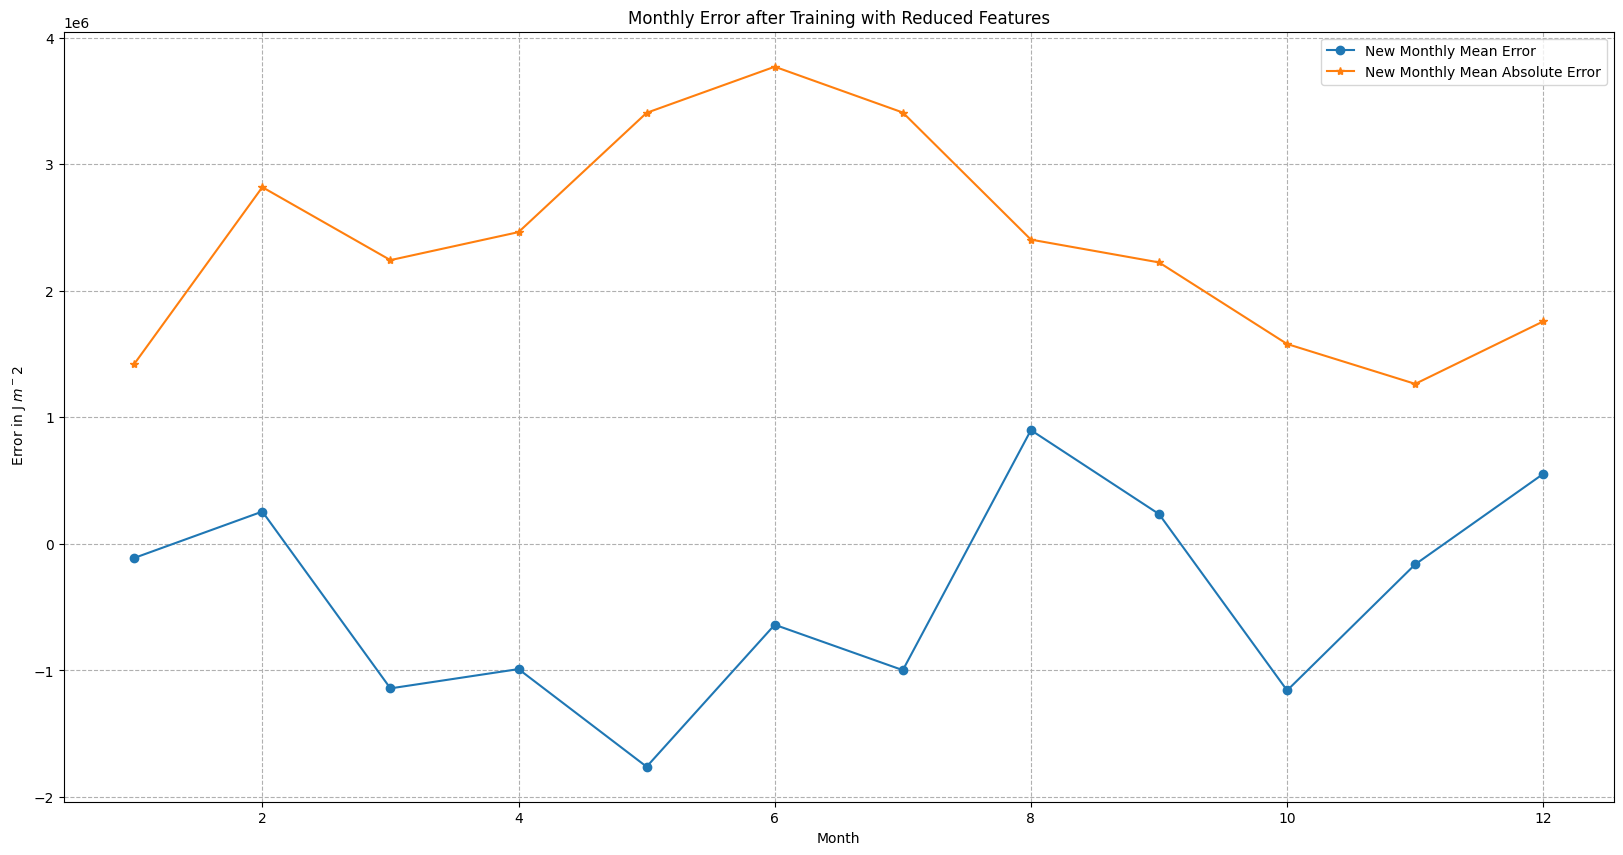

In [320]:
plt.plot(test_df.index.month.unique(), new_mean_monthly_error, '-o', label= 'New Monthly Mean Error')
plt.plot(test_df.index.month.unique(), new_abs_mean_monthly_error,'-*', label='New Monthly Mean Absolute Error')

plt.xlabel('Month')
plt.ylabel(' Error in J $m^-2$')
plt.title('Monthly Error after Training with Reduced Features')
plt.grid(linestyle='--')
plt.legend();

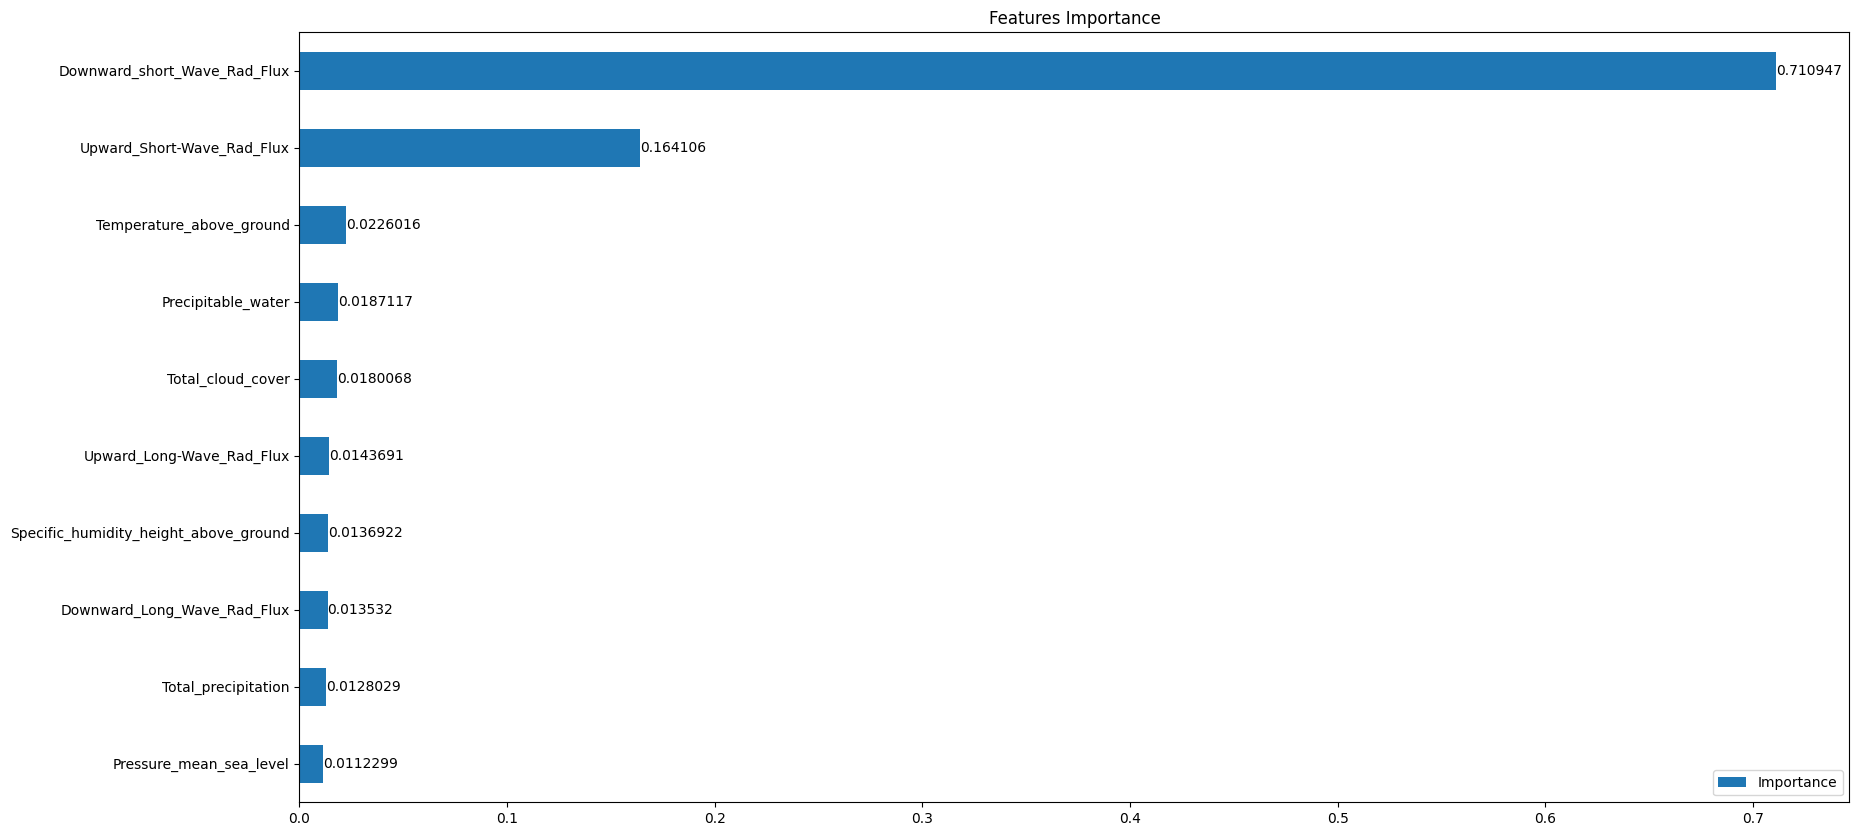

In [321]:
#New Feature importance from the Regression Tree
feat_imp_new= pd.DataFrame(data= new_reg.feature_importances_,
             index= new_reg.feature_names_in_,
             columns=['Importance'])
ax=feat_imp_new.sort_values('Importance').plot(kind='barh',title= 'Features Importance')

ax.bar_label(ax.containers[0]);

In [322]:
new_x_test= test_df[new_features]
new_y_test= test_df[label]

In [323]:
# Compute permutation importance
new_result = permutation_importance(new_reg, new_x_test, new_y_test, scoring='neg_root_mean_squared_error', random_state=40)
new_result.importances

array([[ 179300.11033801,  103329.73401504,  103277.13355202,
          62833.61720322,  107080.56666089],
       [ 668166.07680769,  730611.11955005,  668958.68405663,
         803267.60590906,  713233.78608239],
       [3704073.15221898, 3980175.02554461, 3892057.97754341,
        3620105.51597302, 3421223.07147143],
       [  38787.07657571,   84499.68599126,   59327.45879807,
          82567.74352448,   57964.99314065],
       [1898727.49394966, 1966562.03014432, 1841331.74640334,
        1587654.61771542, 1986577.28613198],
       [ 111985.42849306,   94085.96303016,  118096.85981584,
          89387.73963914,   45529.00296436],
       [ 323526.20343845,  651212.37005985,  481918.40499746,
         436300.05074935,  228081.88228866],
       [1545306.59775377, 1640162.09828015, 1711903.13588102,
        1678162.24548561, 1670833.31013342],
       [  48468.30512043,   28437.54765867,   82369.87518275,
          91754.4658211 ,   72778.83925918],
       [ 501087.12305835,  454612.258

In [324]:
# Compute scores after permutation
new_perm_scores = new_result.importances_mean

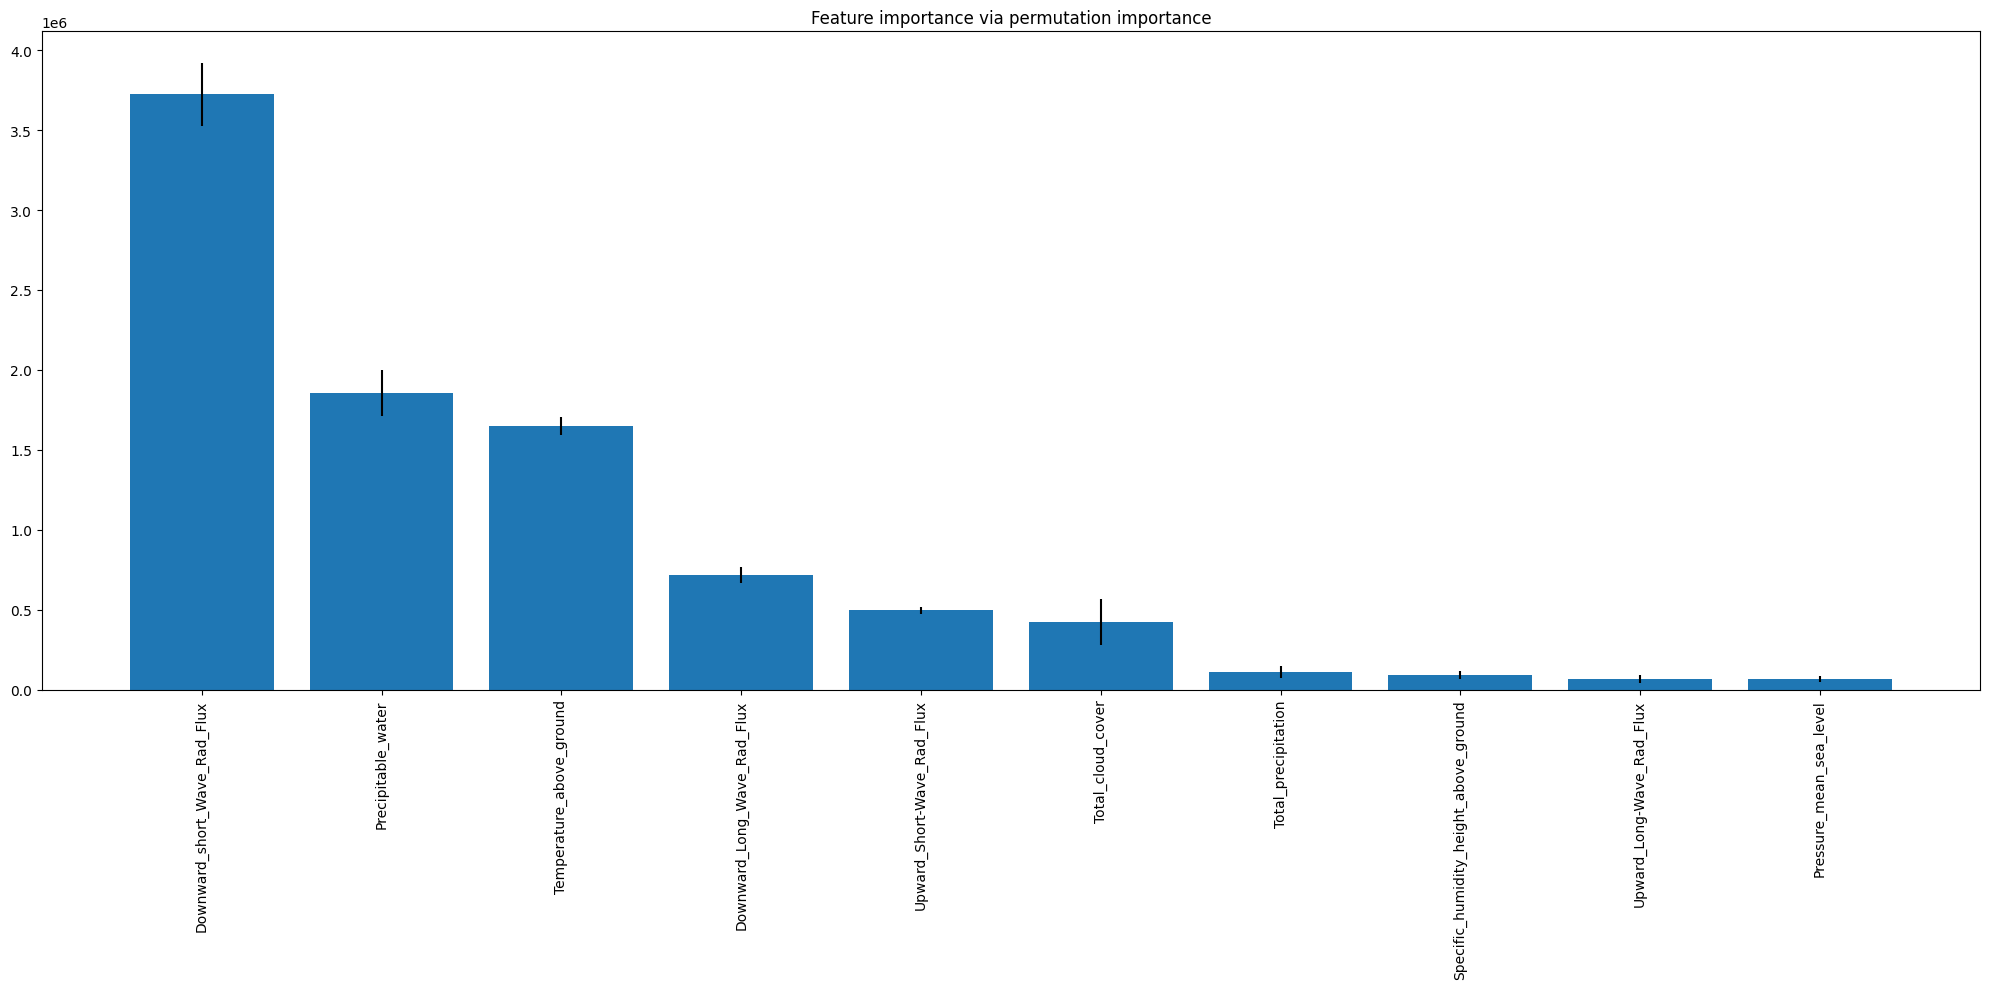

In [325]:
#Visualise
new_indices = np.argsort(new_perm_scores)[::-1]

plt.figure()
plt.title("Feature importance via permutation importance")
plt.bar(
    range(new_x_test.shape[1]),
    new_result['importances_mean'][new_indices],
    yerr=new_result['importances_std'][new_indices]
)

new_feature_names = new_x_train.columns.values
plt.xticks(range(new_x_train.shape[1]), new_feature_names[new_indices], rotation=90)


plt.tight_layout()

####Recursive Feature Elimination


In [326]:
from sklearn.feature_selection import RFECV

In [327]:
# Create the RFE object with cross-validation
selector = RFECV(estimator=new_reg, step=1, cv=5)  # Adjust step and cv as needed

# Fit the RFE on the training data
selector.fit(new_x_train, new_y_train)

# Get the ranking of features
feature_ranking = selector.ranking_

# Get the selected features based on desired number or ranking threshold
selected_features = [new_features[i] for i, r in enumerate(feature_ranking) if r == 1]

# Use the selected features for further analysis or train a new model
print("Selected Features:", selected_features)

Selected Features: ['Total_precipitation', 'Downward_Long_Wave_Rad_Flux', 'Downward_short_Wave_Rad_Flux', 'Pressure_mean_sea_level', 'Precipitable_water', 'Specific_humidity_height_above_ground', 'Total_cloud_cover', 'Temperature_above_ground', 'Upward_Long-Wave_Rad_Flux', 'Upward_Short-Wave_Rad_Flux']


In [328]:
feature_ranking

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

##Hyperparameter Tuning

###Grid Search

In [329]:
from sklearn.model_selection import GridSearchCV

Best Hyperparameters: {'early_stopping_rounds': 50, 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [330]:
#Parameter grid
param_grid = {
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.3, 0.001],
    'n_estimators': [500, 1000, 2000],
    'eval_metric':['rmse']
}

# Creating a GridSearchCV object
grid_search = GridSearchCV(new_reg, param_grid, cv=tss, scoring='neg_root_mean_squared_error')

# Fitting the grid search to the training data
grid_search.fit(train_df[new_features][:-365], train_df[label][:-365], eval_set= [(train_df[new_features][-365:],train_df[label][-365:])],verbose= 200)

#the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

[0]	validation_0-rmse:19478602.85806
[200]	validation_0-rmse:4082681.37850
[400]	validation_0-rmse:2938466.69531
[499]	validation_0-rmse:2891163.16979
[0]	validation_0-rmse:19479253.95365
[200]	validation_0-rmse:4075594.52357
[400]	validation_0-rmse:2894466.84498
[499]	validation_0-rmse:2836794.00666
[0]	validation_0-rmse:19478904.88360
[200]	validation_0-rmse:4130975.34773
[400]	validation_0-rmse:2900789.79203
[499]	validation_0-rmse:2850609.89490
[0]	validation_0-rmse:19479831.91122
[200]	validation_0-rmse:4179938.94681
[400]	validation_0-rmse:2908693.50165
[499]	validation_0-rmse:2843828.89326
[0]	validation_0-rmse:19479877.50164
[200]	validation_0-rmse:4189197.10467
[400]	validation_0-rmse:2922730.29169
[499]	validation_0-rmse:2856683.03302
[0]	validation_0-rmse:19478602.85806
[200]	validation_0-rmse:4082681.37850
[400]	validation_0-rmse:2938466.69531
[600]	validation_0-rmse:2889433.92675
[800]	validation_0-rmse:2888392.62172
[999]	validation_0-rmse:2891078.25508
[0]	validation_0-r

Best Hyperparameters: {'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2000}

####Hyperband

In [331]:
from hyperopt import hp, fmin, tpe

In [483]:
# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 1000, 2500, 100),
    'max_depth': hp.quniform('max_depth', 3, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'gamma': hp.uniform('gamma', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
}

# Define the objective function to minimize (RMSE)
def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'gamma': params['gamma'],
              'colsample_bytree': params['colsample_bytree']
              }
    tss = TimeSeriesSplit(test_size=365)
    new_scores2 = []

    for train_index, val_index in tss.split(train_df):
        traindf = train_df.copy()
        train = traindf.iloc[train_index]
        val = traindf.iloc[val_index]

        new_x_train = train[new_features]
        new_y_train = train[label]

        new_x_val = val[new_features]
        new_y_val = val[label]

        # Create XGBRegressor with hyperparameters from 'params'
        new_reg2 = xgb.XGBRegressor(
            base_score=0.5, booster='gbtree',early_stopping_rounds=50, **params)

        # Fit the model with early stopping
        new_reg2.fit(new_x_train, new_y_train,
                    eval_set=[(new_x_train, new_y_train), (new_x_val, new_y_val)],
                    verbose=False)

        new_y_pred = new_reg2.predict(new_x_val)
        new_score = np.sqrt(mean_squared_error(new_y_val, new_y_pred))
        new_scores2.append(new_score)

    return new_scores2[-1]  # Minimize the last RMSE

# Perform Hyperband optimization
best_params2 = fmin(objective, space, algo= tpe.suggest, max_evals=100)

100%|██████████| 100/100 [03:39<00:00,  2.19s/trial, best loss: 2684480.956311625]


In [495]:
best_params

{'eval_metric': 'rmse',
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 2000}

In [484]:
best_params2

{'colsample_bytree': 0.6306897829412301,
 'gamma': 4.071477079399462,
 'learning_rate': 0.1085285990899901,
 'max_depth': 3.0,
 'n_estimators': 1900.0}

In [485]:
best_params2['max_depth']=int(best_params2['max_depth'])
best_params2['n_estimators']= int(best_params2['n_estimators'])

In [496]:
#Train a final XGBoost model with the best hyperparameters
new_reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree', **best_params)
new_reg2.fit(train_df[new_features], train_df[label])


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [497]:
new_prediction2 = new_reg2.predict(test_df[new_features])

In [498]:
#Test Scores

In [499]:
#R2 Score
new_r22 = new_reg2.score(test_df[new_features], y_test)
new_r22

0.7933862008433608

In [500]:
#change in r2
new_r22-new_r2

0.008703544958929332

In [501]:
#Mean Absolute Error
new_mae2= mae(new_prediction2, y_test)
new_mae2

2373725.210616438

In [502]:
#change in MAE
new_mae2 - new_mae

-18853.494520548265

In [503]:
#RMSE
new_rmse2= np.sqrt(mean_squared_error(new_prediction2,y_test))
new_rmse2

3232521.3702108823

In [504]:
#change in RMSE
new_rmse2 - new_rmse

-67382.20741680777

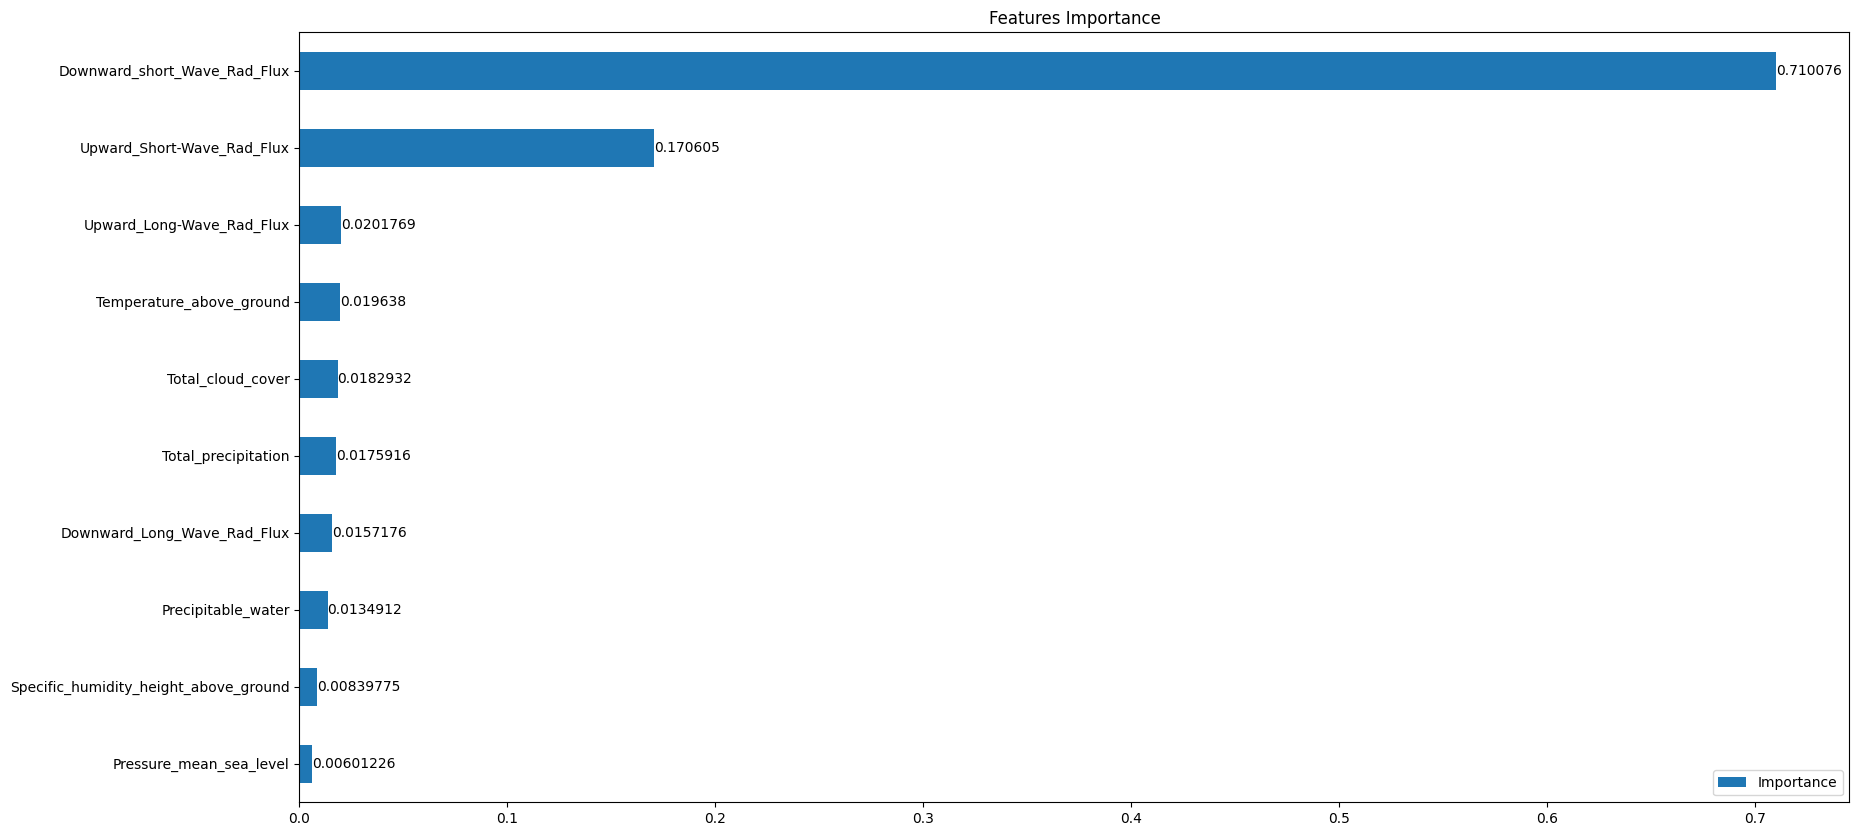

In [505]:
feat_imp_new2= pd.DataFrame(data= new_reg2.feature_importances_,
             index= new_reg2.feature_names_in_,
             columns=['Importance'])
ax=feat_imp_new2.sort_values('Importance').plot(kind='barh',title= 'Features Importance')
ax.bar_label(ax.containers[0]);

In [506]:
test_df['New Primary Prediction 2']= new_prediction2
test_df['new error 2']= test_df['New Primary Prediction 2']- test_df['radiation']

In [507]:
new_mean_monthly_error2 = test_df['new error 2'].groupby(test_df.index.month).mean()

In [508]:
new_abs_mean_monthly_error2= abs(test_df['new error 2']).groupby(test_df.index.month).mean()

Change in Error

In [509]:
new_mean_monthly_error - new_mean_monthly_error2

1     110723.842742
2      80506.160714
3     -72329.040323
4    -238698.433333
5    -299040.838710
6    -174401.133333
7    -353793.967742
8    -153757.322581
9     -34887.000000
10     23814.322581
11   -113446.116667
12    112501.157258
dtype: float64

In [510]:
new_abs_mean_monthly_error - new_abs_mean_monthly_error2

1      40091.028226
2     -25187.553571
3       8868.685484
4    -127148.766667
5     143326.193548
6    -248088.133333
7     471689.774194
8     -53653.774194
9    -202038.333333
10     36696.903226
11     23168.083333
12    133948.657258
dtype: float64

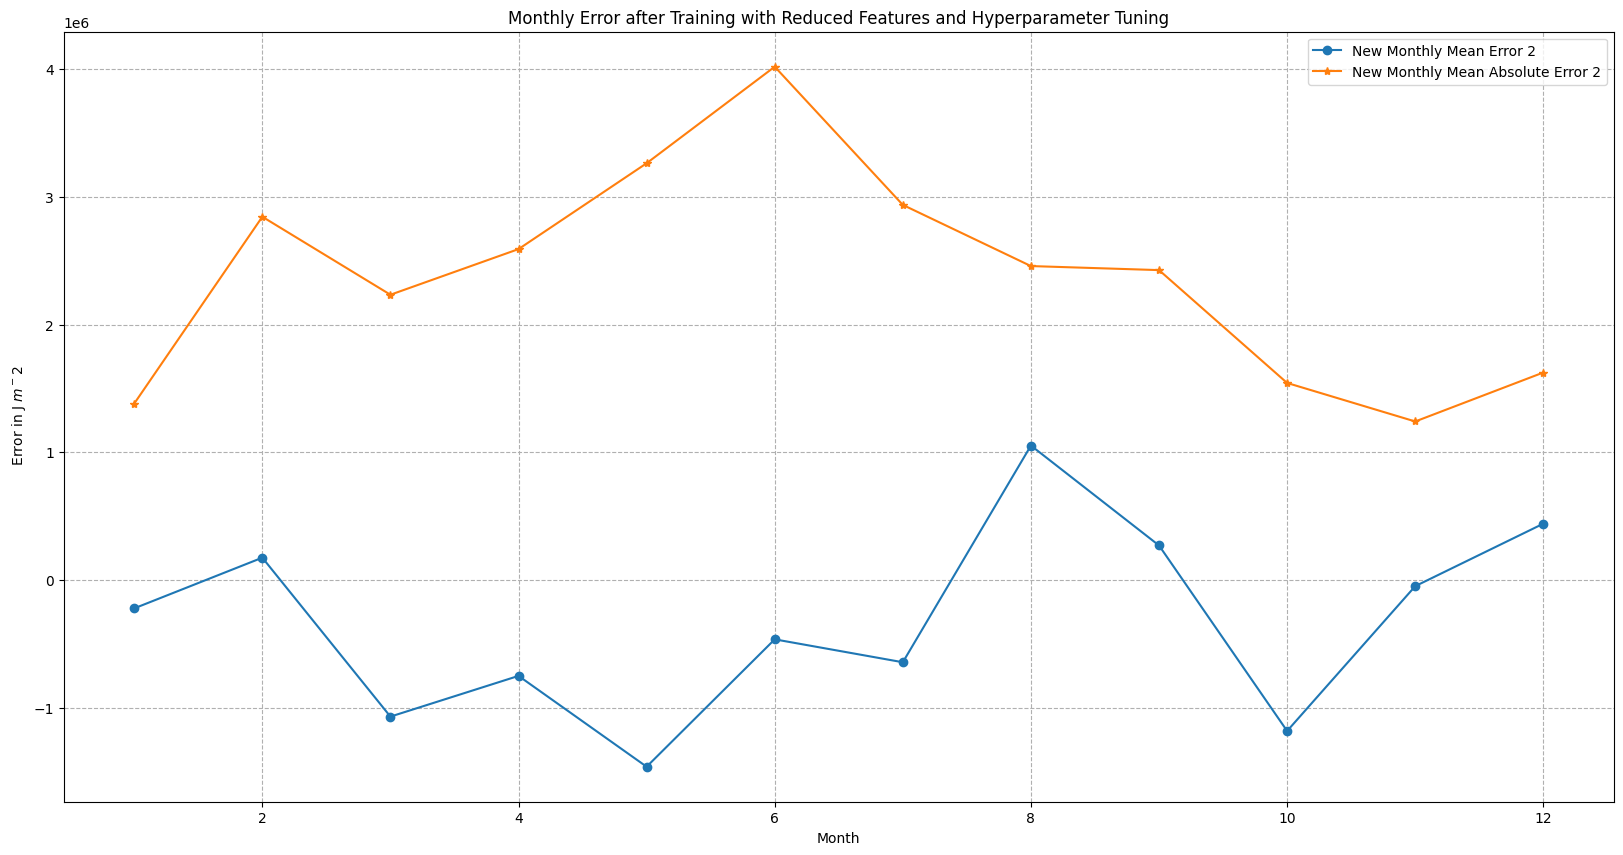

In [513]:
plt.plot(test_df.index.month.unique(), new_mean_monthly_error2, '-o', label= 'New Monthly Mean Error 2')
plt.plot(test_df.index.month.unique(), new_abs_mean_monthly_error2,'-*', label='New Monthly Mean Absolute Error 2')

plt.xlabel('Month')
plt.ylabel(' Error in J $m^-2$')
plt.title('Monthly Error after Training with Reduced Features and Hyperparameter Tuning')
plt.grid(linestyle='--')
plt.legend();

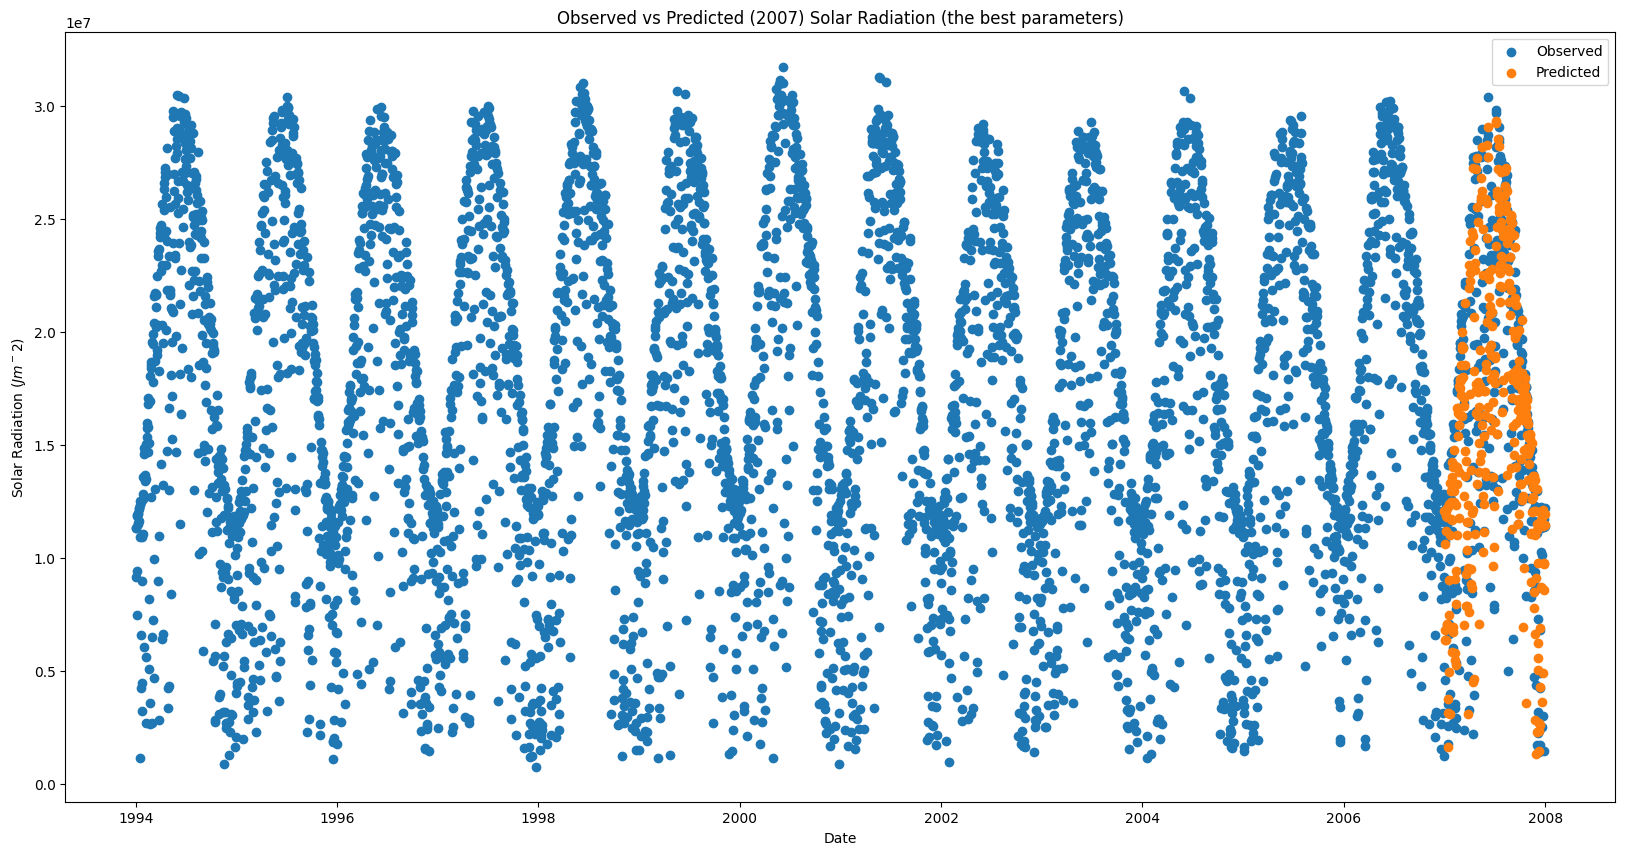

In [514]:
#Final Prediction Plot
plt.scatter(df.index,solar_df['WEAT'], label='Observed' )
plt.scatter(test_df.index,new_prediction2, label= 'Predicted')
plt.xlabel('Date')
plt.ylabel('Solar Radiation ($J m^-2)$')
plt.title('Observed vs Predicted (2007) Solar Radiation (the best parameters)')
plt.legend();